In [2]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [6]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class, model_dir, lang_class, lang_path = (conf.get(k) for k in ("model_class", "model_dir", "lang_class", "lang_path"))
lang_class = class_from_package("language", lang_class)
lang = lang_class.load(repo_root + lang_path)
model_class = class_from_package("transition", model_class)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class, reward_conf = (conf.get(k) for k in ("reward_class", "reward_conf"))
reward_class = class_from_package("reward", reward_class)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class", "policy_conf"))
policy_class = class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

Search is started.
0- time: 0.01, count_rollouts: 1, reward: -0.8996211848009638, node: PEPTIDE1{Y.G.A.F.L.R.R.I.R.P.K.L.K.[am]}$$$$
1- time: 0.17, count_rollouts: 2, reward: -0.8636451832901021, node: PEPTIDE1{R.R.R.W.A.R.W.F}$$$$
2- time: 0.19, count_rollouts: 3, reward: -0.924359065690482, node: PEPTIDE1{[ac].F.Q.S.K.K.N.V.F.V.F.G.Y.F.E.R.L.R.E.K.L.[am]}$$$$
3- time: 0.23, count_rollouts: 4, reward: -0.8877249796302725, node: PEPTIDE1{R.[dP].K.P.[dQ].Q.F.[dY].G.L.M.[am]}$$$$
4- time: 0.26, count_rollouts: 5, reward: -0.8901310935182828, node: PEPTIDE1{Y.V.P.T.N.V.G.S.E.A.F}$$$$
5- time: 0.28, count_rollouts: 6, reward: -0.9296251977911063, node: PEPTIDE1{G.L.Q.G.R.L.Q.R.L.L.Q.A.S.G.N.H.A.A.G.I.L.T.M}$$$$
6- time: 0.36, count_rollouts: 8, reward: -0.9446425817264901, node: PEPTIDE1{A.A.E.A.A.L.E.A.E.L.A.A.L.E.G.W.M.A.V.A.G.R.T.L.G.K.L.A.A.L.K.A.K.L.A.A.L.K.A}$$$$
7- time: 0.43, count_rollouts: 9, reward: -0.8770217958341558, node: PEPTIDE1{T.A.Y.F.L.L.A.G.A.G.R.W.[am]}$$$$
8- time: 0

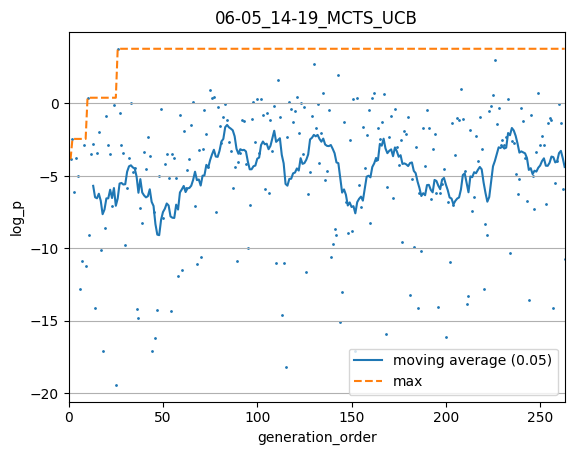

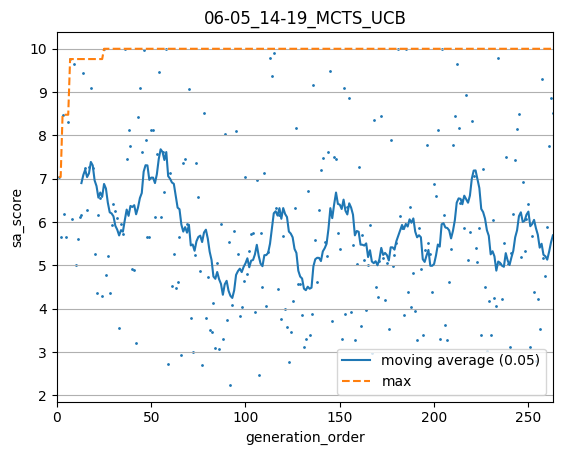

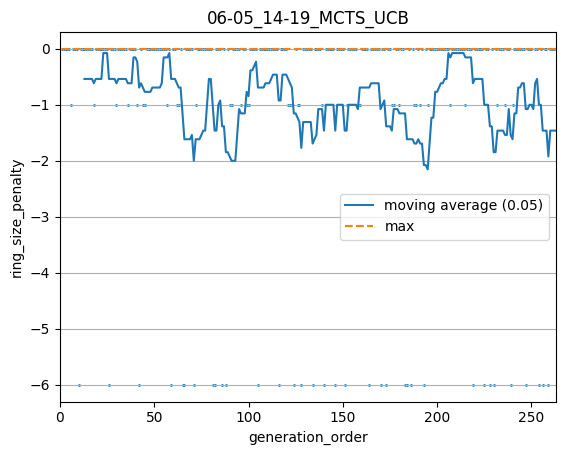

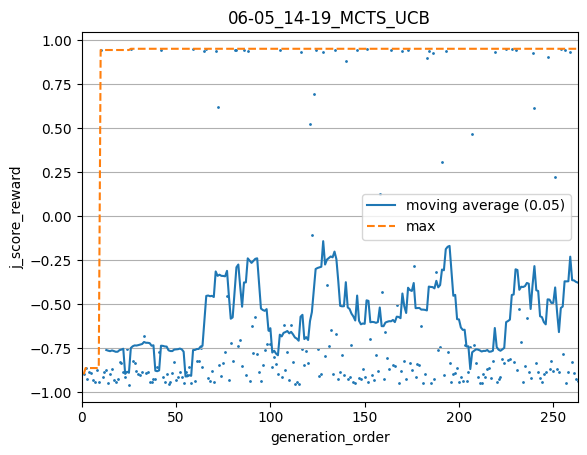

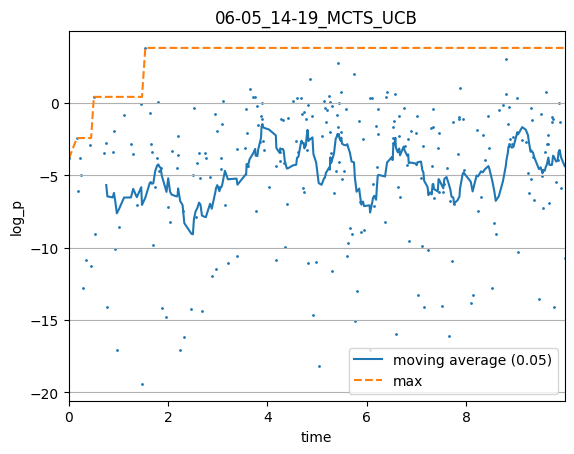

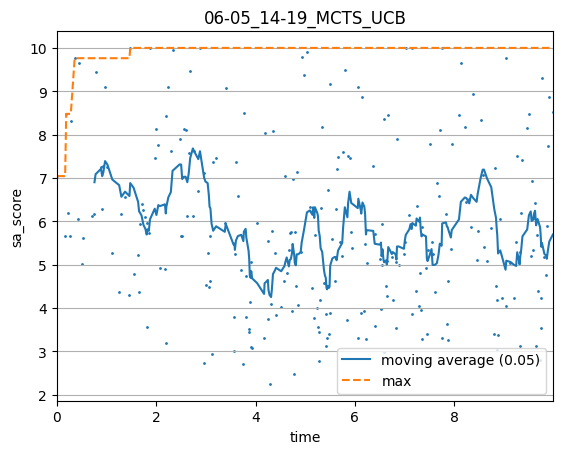

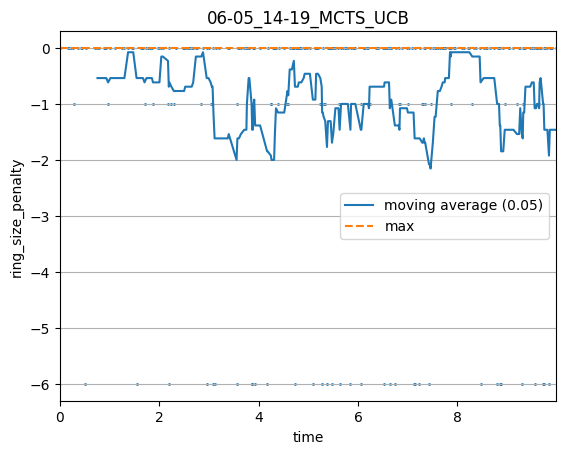

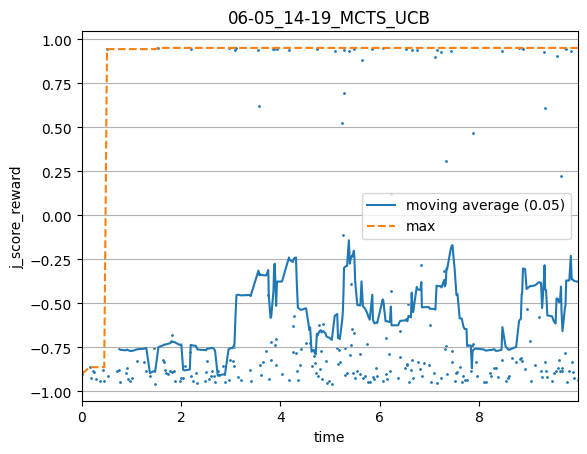

In [8]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
src = repo_root + config_path
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

generator.plot_objective_values_and_reward(x_axis = "generation_order")
generator.plot_objective_values_and_reward(x_axis = "time")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)